In [9]:
from data import generate_dataset
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns

n = 1000

x, y, y_noisy1 = generate_dataset(n=n, noise_std=0.5, random_state=1)
_, _, y_noisy2 = generate_dataset(n=n, noise_std=1.0, random_state=1)
_, _, y_noisy3 = generate_dataset(n=n, noise_std=2.0, random_state=1)
_, _, y = generate_dataset(n=n, noise_std=0, random_state=1)

In [10]:

def design_matrix(x, degree):
    return np.vstack([x**i for i in range(degree+1)]).T

def mse(y, y_hat):
    return np.mean((y - y_hat)**2)

def r2(y, y_hat):
    return 1 - np.sum((y - y_hat)**2) / np.sum((y - np.mean(y))**2)

x_train, x_test = train_test_split(x, test_size=0.2, random_state=42)


_, _, y1_train, y1_test = train_test_split(x, y_noisy1, test_size=0.2, random_state=42)
_, _, y2_train, y2_test = train_test_split(x, y_noisy2, test_size=0.2, random_state=42)
_, _, y3_train, y3_test = train_test_split(x, y_noisy3, test_size=0.2, random_state=42)
_, _, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train.reshape(-1, 1)).flatten()
x_test_scaled = scaler.transform(x_test.reshape(-1, 1)).flatten()

In [11]:
def gd_LASSO(X_train, y_train, X_test, y_test, eta=0.1, num_iters=100, lam=0.1):
    n, d = X_train.shape
    theta = np.zeros(d)
    mse_train, mse_test = [], []
    for _ in range(num_iters):
        grad = (2.0/n) * (X_train.T @ (X_train @ theta - y_train))
        subgrad = lam * np.sign(theta)
        total_grad = grad + subgrad
        theta -= eta * total_grad
        mse_train.append(mse(y_train, X_train @ theta))
        mse_test.append(mse(y_test,  X_test @ theta))
    return theta, mse_train, mse_test
   

def gd_momentum_LASSO(X_train, y_train, X_test, y_test, lam=0.1, eta=0.01, num_iters=1000, gamma=0.9):
    n, d = X_train.shape
    theta = np.zeros(d)
    v = np.zeros(d)
    mse_train, mse_test = [], []
    for _ in range(num_iters):
        grad = (2.0/n) * (X_train.T @ (X_train @ theta - y_train))
        subgrad = lam * np.sign(theta)
        total_grad = grad + subgrad
        v = gamma * v + eta * total_grad
        theta -= v
        mse_train.append(mse(y_train, X_train @ theta))
        mse_test.append(mse(y_test,  X_test @ theta))
    
    return theta, mse_train, mse_test

def gd_adagrad_LASSO(X_train, y_train, X_test, y_test, lam=0.1, eta=0.01, num_iters=1000, eps=1e-8):
    n, d = X_train.shape
    theta = np.zeros(d)
    G = np.zeros(d)
    mse_train, mse_test = [], []
    for _ in range(num_iters):
        grad = (2.0/n) * (X_train.T @ (X_train @ theta - y_train))
        subgrad = lam * np.sign(theta)
        total_grad = grad + subgrad
        G += total_grad**2
        theta -= (eta / (np.sqrt(G) + eps)) * total_grad
        mse_train.append(mse(y_train, X_train @ theta))
        mse_test.append(mse(y_test,  X_test @ theta))
    return theta, mse_train, mse_test

def gd_rmsprop_LASSO(X_train, y_train, X_test, y_test, lam=0.1, eta=0.01, num_iters=1000, beta=0.9, eps=1e-8):
    n, d = X_train.shape
    theta = np.zeros(d)
    Eg = np.zeros(d)
    mse_train, mse_test = [], []
    for _ in range(num_iters):
        grad = (2.0/n) * (X_train.T @ (X_train @ theta - y_train))
        subgrad = lam * np.sign(theta)
        total_grad = grad + subgrad
        Eg = beta * Eg + (1-beta) * total_grad**2
        theta -= (eta / (np.sqrt(Eg) + eps)) * total_grad
        mse_train.append(mse(y_train, X_train @ theta))
        mse_test.append(mse(y_test,  X_test @ theta))
    return theta, mse_train, mse_test

def gd_adam_LASSO(X_train, y_train, X_test, y_test, lam=0.1, eta=0.01, num_iters=1000, beta1=0.9, beta2=0.999, eps=1e-8):
    n, d = X_train.shape
    theta = np.zeros(d)
    m = np.zeros(d)
    v = np.zeros(d)
    mse_train, mse_test = [], []
    for t in range(1, num_iters+1):
        grad = (2.0/n) * (X_train.T @ (X_train @ theta - y_train))
        subgrad = lam * np.sign(theta)
        total_grad = grad + subgrad
        m = beta1*m + (1-beta1)*total_grad
        v = beta2*v + (1-beta2)*(total_grad**2)
        m_hat = m / (1 - beta1**t)
        v_hat = v / (1 - beta2**t)
        theta -= eta * m_hat / (np.sqrt(v_hat) + eps)
        mse_train.append(mse(y_train, X_train @ theta))
        mse_test.append(mse(y_test,  X_test @ theta))
    return theta, mse_train, mse_test

def run_optimizer_experiments_LASSO(
    x_train, y_train, x_test, y_test,
    degrees,
    lams=None,
    etas=None,
    num_iters=1000
):
    if lams is None:
        lams = [1e-6, 1e-3, 1, 3, 10]
    if etas is None:
        etas = [1e-6, 1e-4, 1e-3, 1e-2, 0.05]

    results = []

    for degree in degrees:
        X_train = design_matrix(x_train, degree)
        X_test  = design_matrix(x_test, degree)

        for lam in lams:
            for eta in etas:
                methods = {
                    "Gradient Descent": (lambda lam=lam, eta=eta:
                        gd_LASSO(X_train, y_train, X_test, y_test,
                                 eta=eta, lam=lam, num_iters=num_iters)),
                    "Momentum": (lambda lam=lam, eta=eta:
                        gd_momentum_LASSO(X_train, y_train, X_test, y_test,
                                          eta=eta, lam=lam, num_iters=num_iters)),
                    "AdaGrad": (lambda lam=lam, eta=eta:
                        gd_adagrad_LASSO(X_train, y_train, X_test, y_test,
                                         eta=eta, lam=lam, num_iters=num_iters)),
                    "RMSProp": (lambda lam=lam, eta=eta:
                        gd_rmsprop_LASSO(X_train, y_train, X_test, y_test,
                                         eta=eta, lam=lam, num_iters=num_iters)),
                    "Adam": (lambda lam=lam, eta=eta:
                        gd_adam_LASSO(X_train, y_train, X_test, y_test,
                                      eta=eta, lam=lam, num_iters=num_iters)),
                }

                for name, f in methods.items():
                    _, train_hist, test_hist = f()
                    for t, (tr, te) in enumerate(zip(train_hist, test_hist), start=1):
                        results.append([name, degree, lam, eta, t, tr, te])

    df = pd.DataFrame(
        results,
        columns=["Method", "Degree", "Lambda", "Eta", "Iteration", "Train MSE", "Test MSE"]
    )
    return df


In [12]:
df_lasso = run_optimizer_experiments_LASSO(
    x_train_scaled, y1_train, x_test_scaled, y1_test,
    degrees=range(1,16),
    lams=[1e-6, 1e-3, 1, 3, 10],
    etas=[1e-6, 1e-4, 1e-3, 1e-2, 0.05],
    num_iters=1000
)


c:\hermanis\miniconda3\envs\geo\Lib\site-packages\numpy\core\_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\Herman Nissen-Sollie\AppData\Local\Temp\ipykernel_22820\2141137981.py:5: RuntimeWarning: overflow encountered in square
  return np.mean((y - y_hat)**2)
C:\Users\Herman Nissen-Sollie\AppData\Local\Temp\ipykernel_22820\2532477283.py:6: RuntimeWarning: overflow encountered in matmul
  grad = (2.0/n) * (X_train.T @ (X_train @ theta - y_train))
C:\Users\Herman Nissen-Sollie\AppData\Local\Temp\ipykernel_22820\2532477283.py:6: RuntimeWarning: invalid value encountered in matmul
  grad = (2.0/n) * (X_train.T @ (X_train @ theta - y_train))
C:\Users\Herman Nissen-Sollie\AppData\Local\Temp\ipykernel_22820\2532477283.py:9: RuntimeWarning: invalid value encountered in subtract
  theta -= eta * total_grad
C:\Users\Herman Nissen-Sollie\AppData\Local\Temp\ipykernel_22820\2532477283.py:21: RuntimeWarning: ove

In [13]:
final_lasso = (
    df_lasso.sort_values("Iteration")
            .groupby(["Method","Degree","Lambda","Eta"], as_index=False)
            .tail(1)
)
final_lasso = final_lasso[np.isfinite(final_lasso["Test MSE"])]
final_lasso = final_lasso[final_lasso["Test MSE"] < 1e3]


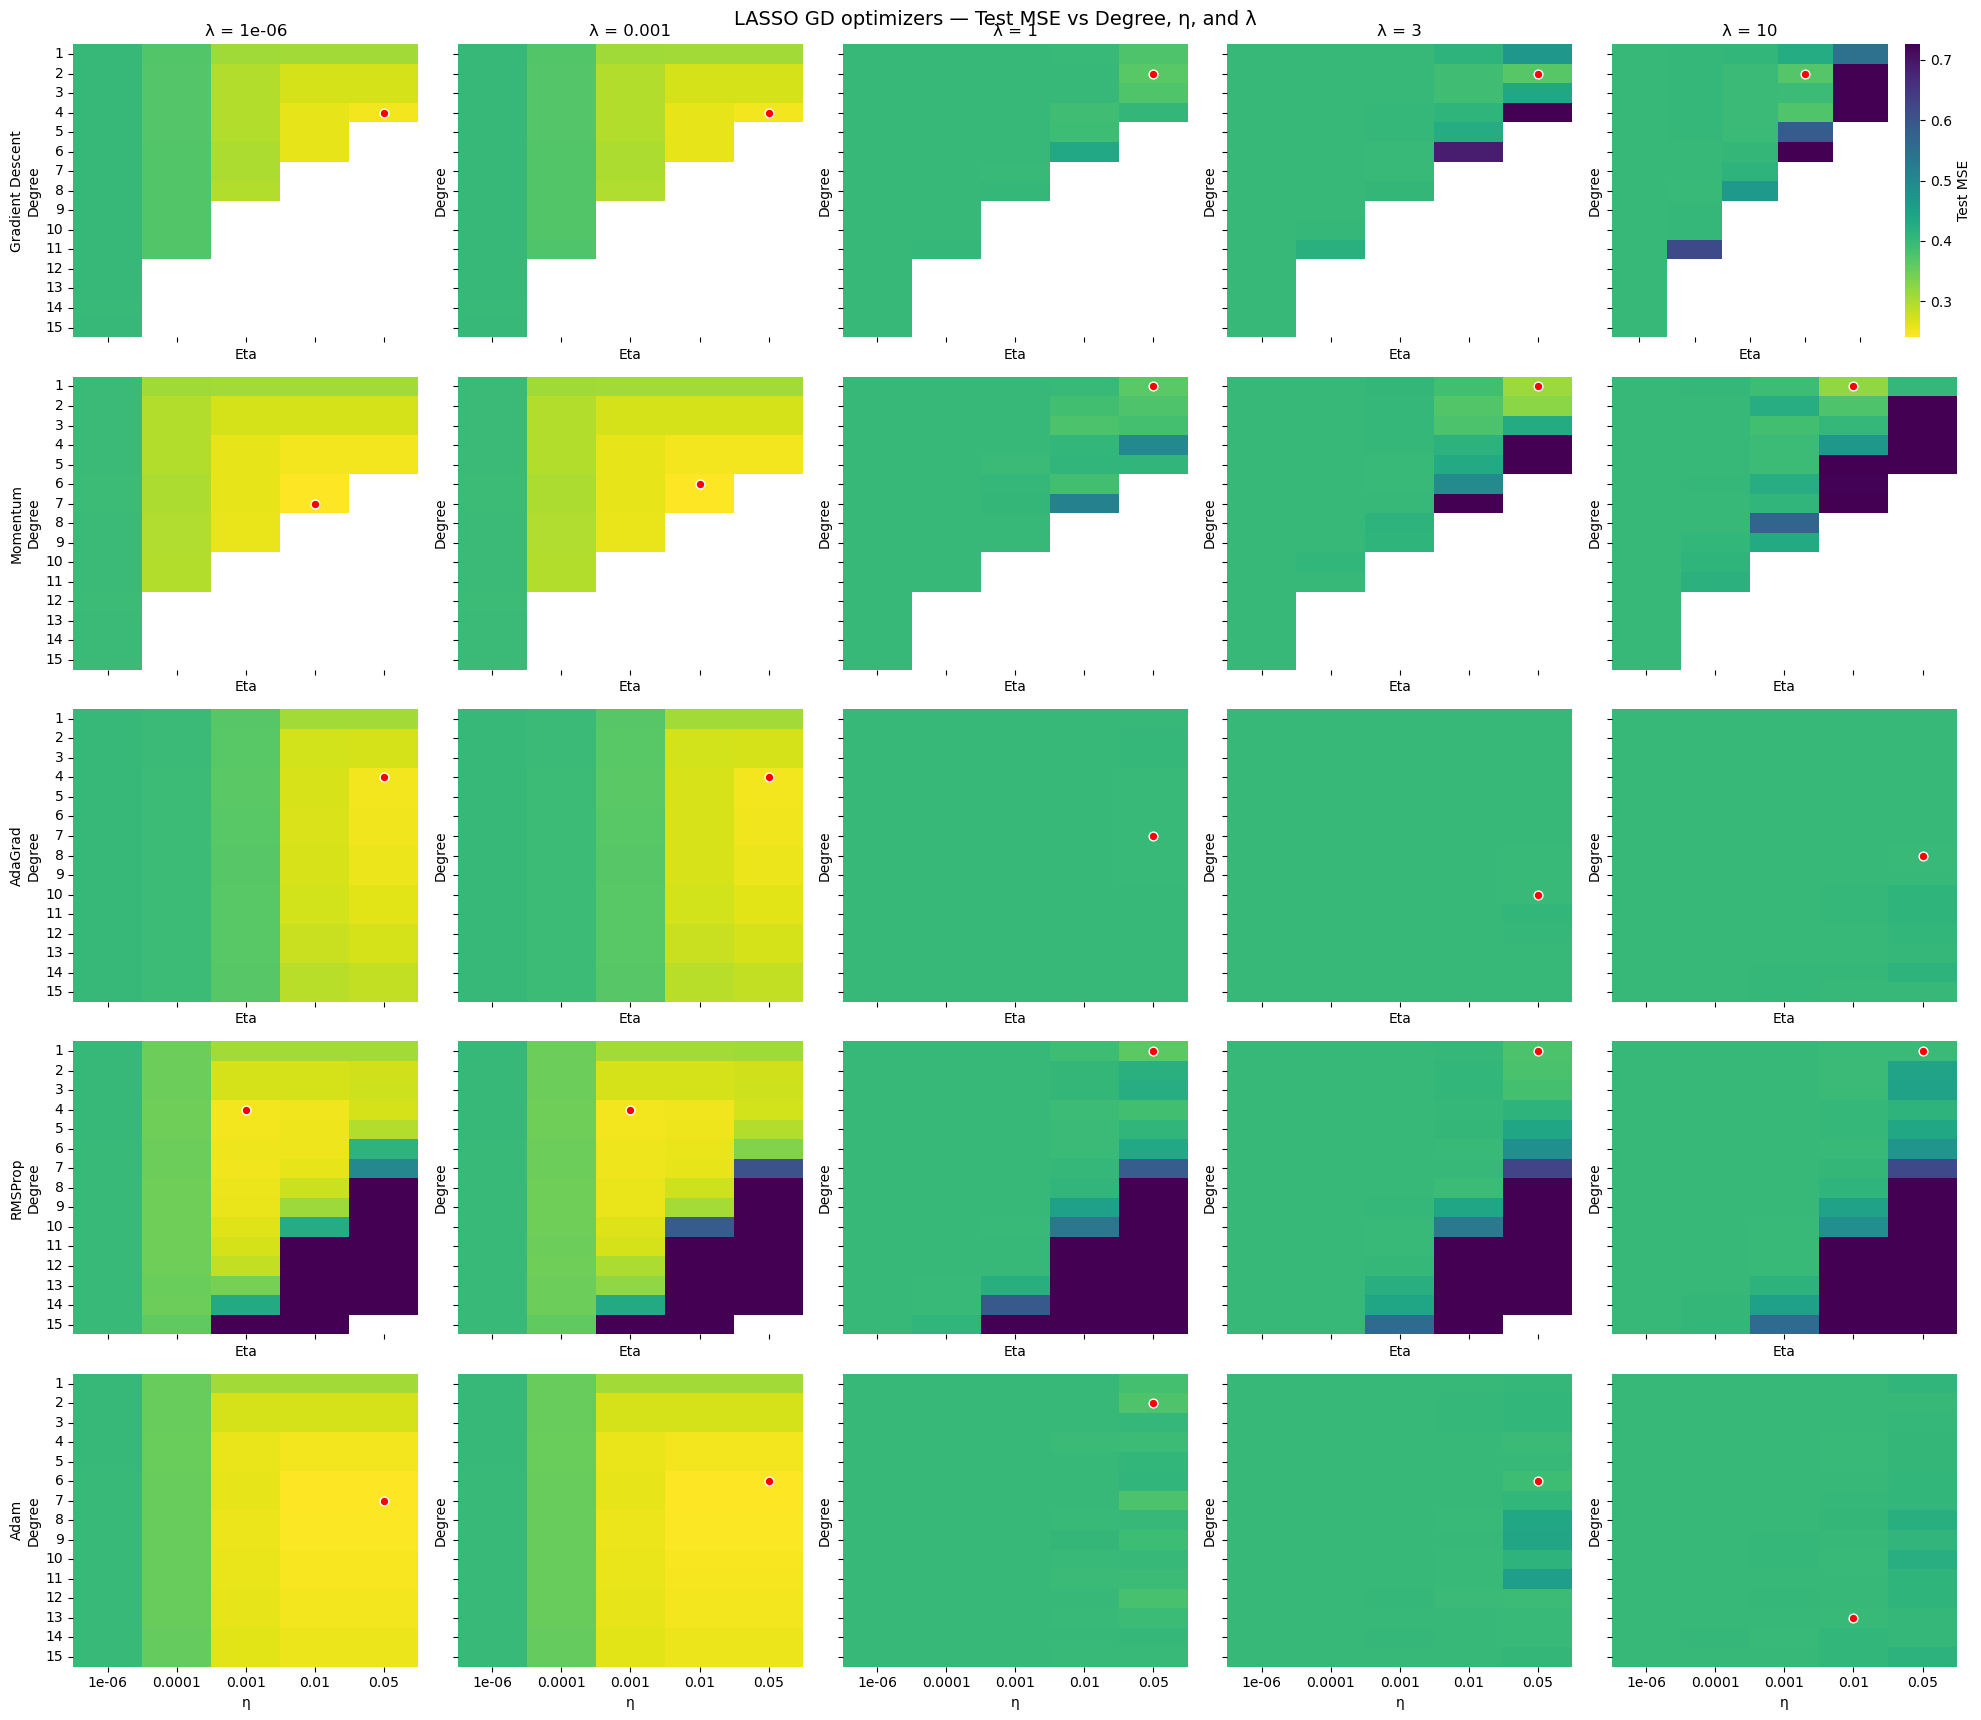

In [16]:
methods = ["Gradient Descent", "Momentum", "AdaGrad", "RMSProp", "Adam"]
lambdas = sorted(final_lasso["Lambda"].unique())

fig, axes = plt.subplots(len(methods), len(lambdas),
                         figsize=(4*len(lambdas), 3.5*len(methods)),
                         sharex=True, sharey=True)

vmin = final_lasso["Test MSE"].min()
vmax = final_lasso["Test MSE"].quantile(0.95)

for i, method in enumerate(methods):
    for j, lam in enumerate(lambdas):
        ax = axes[i, j]
        subset = final_lasso[(final_lasso["Method"] == method) & (final_lasso["Lambda"] == lam)]
        pivot = subset.pivot_table(index="Degree", columns="Eta", values="Test MSE", aggfunc="mean")

        if pivot.empty:
            ax.axis("off")
            continue

        sns.heatmap(pivot, cmap="viridis_r", vmin=vmin, vmax=vmax,
                    annot=False, ax=ax, cbar=(i == 0 and j == len(lambdas)-1),
                    cbar_kws={'label':'Test MSE'})

  
        min_idx = np.unravel_index(np.nanargmin(pivot.values), pivot.shape)
        ax.scatter(min_idx[1] + 0.5, min_idx[0] + 0.5, marker="o", s=40, c="red", edgecolor="white")

        if i == 0: ax.set_title(f"λ = {lam:g}")
        if j == 0: ax.set_ylabel(f"{method}\nDegree")
        if i == len(methods)-1: ax.set_xlabel("η")

plt.suptitle("LASSO GD optimizers — Test MSE vs Degree, η, and λ", fontsize=14)
plt.tight_layout()
plt.show()


In [15]:
best_per_opt = final_lasso.loc[final_lasso.groupby("Method")["Test MSE"].idxmin()]
print(best_per_opt[["Method","Lambda","Eta","Degree","Test MSE"]])


                  Method    Lambda    Eta  Degree  Test MSE
397999           AdaGrad  0.000001  0.050       4  0.248835
674999              Adam  0.001000  0.050       6  0.240267
395999  Gradient Descent  0.000001  0.050       4  0.248882
766999          Momentum  0.000001  0.010       7  0.240962
388999           RMSProp  0.000001  0.001       4  0.249290
